This guide outlines the process for fine-tuning a Vision Transformer (ViT) model on a custom biomedical dataset. It includes steps for loading and preparing the dataset, setting up image transformations for different data splits, configuring and initializing the ViT model, and defining the training process with evaluation and visualization tools.

The custom dataset is hand-made, containing 780 images with 3 classes (benign, malignant, normal).



In [1]:
!pip install -q datasets transformers accelerate torch scikit-learn matplotlib wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00


In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
from datasets import load_dataset

dataset = load_dataset("emre570/breastcancer-ultrasound-images")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/624 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

create the validation set

In [4]:
test_num = len(dataset["test"])
train_num = len(dataset["train"])

val_size = test_num / train_num

train_val_split = dataset["train"].train_test_split(test_size=val_size)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [5]:
from datasets import DatasetDict

dataset = DatasetDict(
    {
        "train": train_val_split["train"],
        "validation": train_val_split["test"],
        "test": dataset["test"]
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [6]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

train_ds[0], train_ds.features

({'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=562x457>,
  'label': 1},
 {'image': Image(mode=None, decode=True, id=None),
  'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)})

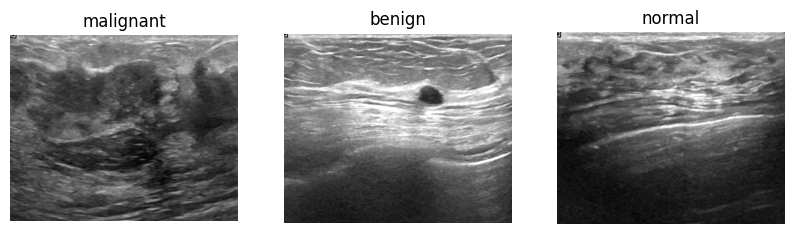

In [7]:
import matplotlib.pyplot as plt

shown_labels = set()

plt.figure(figsize=(10, 10))

for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

## data processing

- Label Mapping: We convert between label IDs and their corresponding names, useful for model training and evaluation.

- Image Processing: Then, we utilize the ViTImageProcessor to standardize input image sizes and applies normalization specific to the pretrained model. Also, will define different transformations for training, validation, and testing to improve model generalization using torchvision.

- Transform Functions: Implement functions to apply the transformations to the dataset, converting images to the required format and dimensions for the ViT model.

- Data Loading: Set up a custom collate function to properly batch images and labels, and create a DataLoader for efficient loading and batching during model training.

- Batch Preparation: Retrieve and display the shape of data in a sample batch to verify correct processing and readiness for model input.

In [8]:
# labelmapping
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}

id2label, id2label[train_ds[0]["label"]]

({0: 'benign', 1: 'malignant', 2: 'normal'}, 'malignant')

In [9]:
# img processing
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-large-patch16-224")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [11]:
# create transform functions
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [12]:
train_ds.features, train_ds[0]

({'image': Image(mode=None, decode=True, id=None),
  'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=562x457>,
  'label': 1,
  'pixel_values': tensor([[[-0.0118, -0.0039,  0.0118,  ...,  0.1059,  0.0824,  0.0431],
           [-0.0039,  0.0275,  0.0588,  ..., -0.0275, -0.0353, -0.0588],
           [ 0.0118,  0.0431,  0.0980,  ..., -0.0039, -0.0118, -0.0196],
           ...,
           [-0.5137, -0.4275, -0.3490,  ..., -0.4745, -0.4745, -0.4667],
           [-0.6471, -0.5686, -0.4824,  ..., -0.4588, -0.4353, -0.4118],
           [-0.7569, -0.7020, -0.6314,  ..., -0.4667, -0.4196, -0.3882]],
  
          [[-0.0118, -0.0039,  0.0118,  ...,  0.1059,  0.0824,  0.0431],
           [-0.0039,  0.0275,  0.0588,  ..., -0.0275, -0.0353, -0.0588],
           [ 0.0118,  0.0431,  0.0980,  ..., -0.0039, -0.0118, -0.0196],
           ...,
           [-0.5137, -0.4275, -0.3490,  ..., -0.4745, -0.4745, -0.4667],
     

## data loading

In [13]:
import torch
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [14]:
# prep batches
batch = next(iter(train_dl))
for k, v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# fine tuning

In [16]:
from transformers import ViTForImageClassification

model_name = "google/vit-large-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True # fix images of different sizes
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments, Trainer
import numpy as np

training_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    report_to="wandb",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=10, # originally 40
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.440979
2,No log,0.408770
3,No log,0.414515
4,No log,0.437967
5,No log,0.356591
6,No log,0.408490
7,No log,0.364216
8,No log,0.396019
9,No log,0.406568
10,No log,0.407287


TrainOutput(global_step=470, training_loss=0.3639233203644448, metrics={'train_runtime': 1094.6062, 'train_samples_per_second': 4.276, 'train_steps_per_second': 0.429, 'total_flos': 1.2820162942631117e+18, 'train_loss': 0.3639233203644448, 'epoch': 10.0})

In [21]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.32695549726486206, 'test_runtime': 7.9299, 'test_samples_per_second': 19.672, 'test_steps_per_second': 4.918}


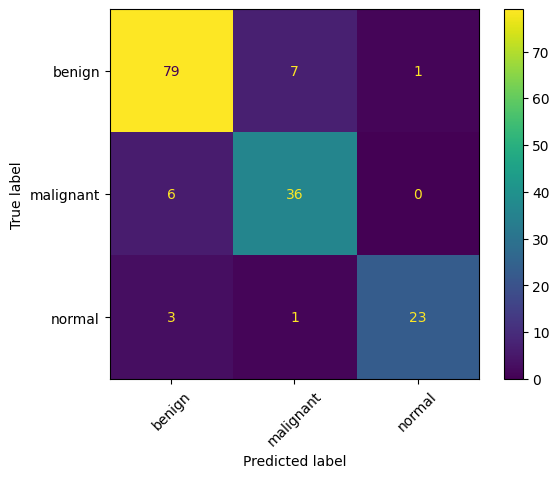

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [23]:
# ability of model to correctly identify all relevant instances within a dataset
from sklearn.metrics import recall_score

# 'None' calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

for label, score in zip(labels, recall):
    print(f"Recall for {label}: {score:.2f}")

Recall for benign: 0.91
Recall for malignant: 0.86
Recall for normal: 0.85
